# Calibrating AL efficacy to different weights/weight groups

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

<br>

# Weights 6 to 60 in increments of 1kg (55 different weights)
## n = 10k

In [3]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))



[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [4]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_calibration_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [38:20<00:00, 41.82s/it]    

DataFrame saved as pickle and CSV files successfully.


In [5]:
df

,weight,efficacy
0,6,32.09
1,7,33.82
2,8,35.84
3,9,36.86
4,10,37.44
5,11,39.20
6,12,40.54
7,13,42.24
8,14,68.38
9,15,69.33


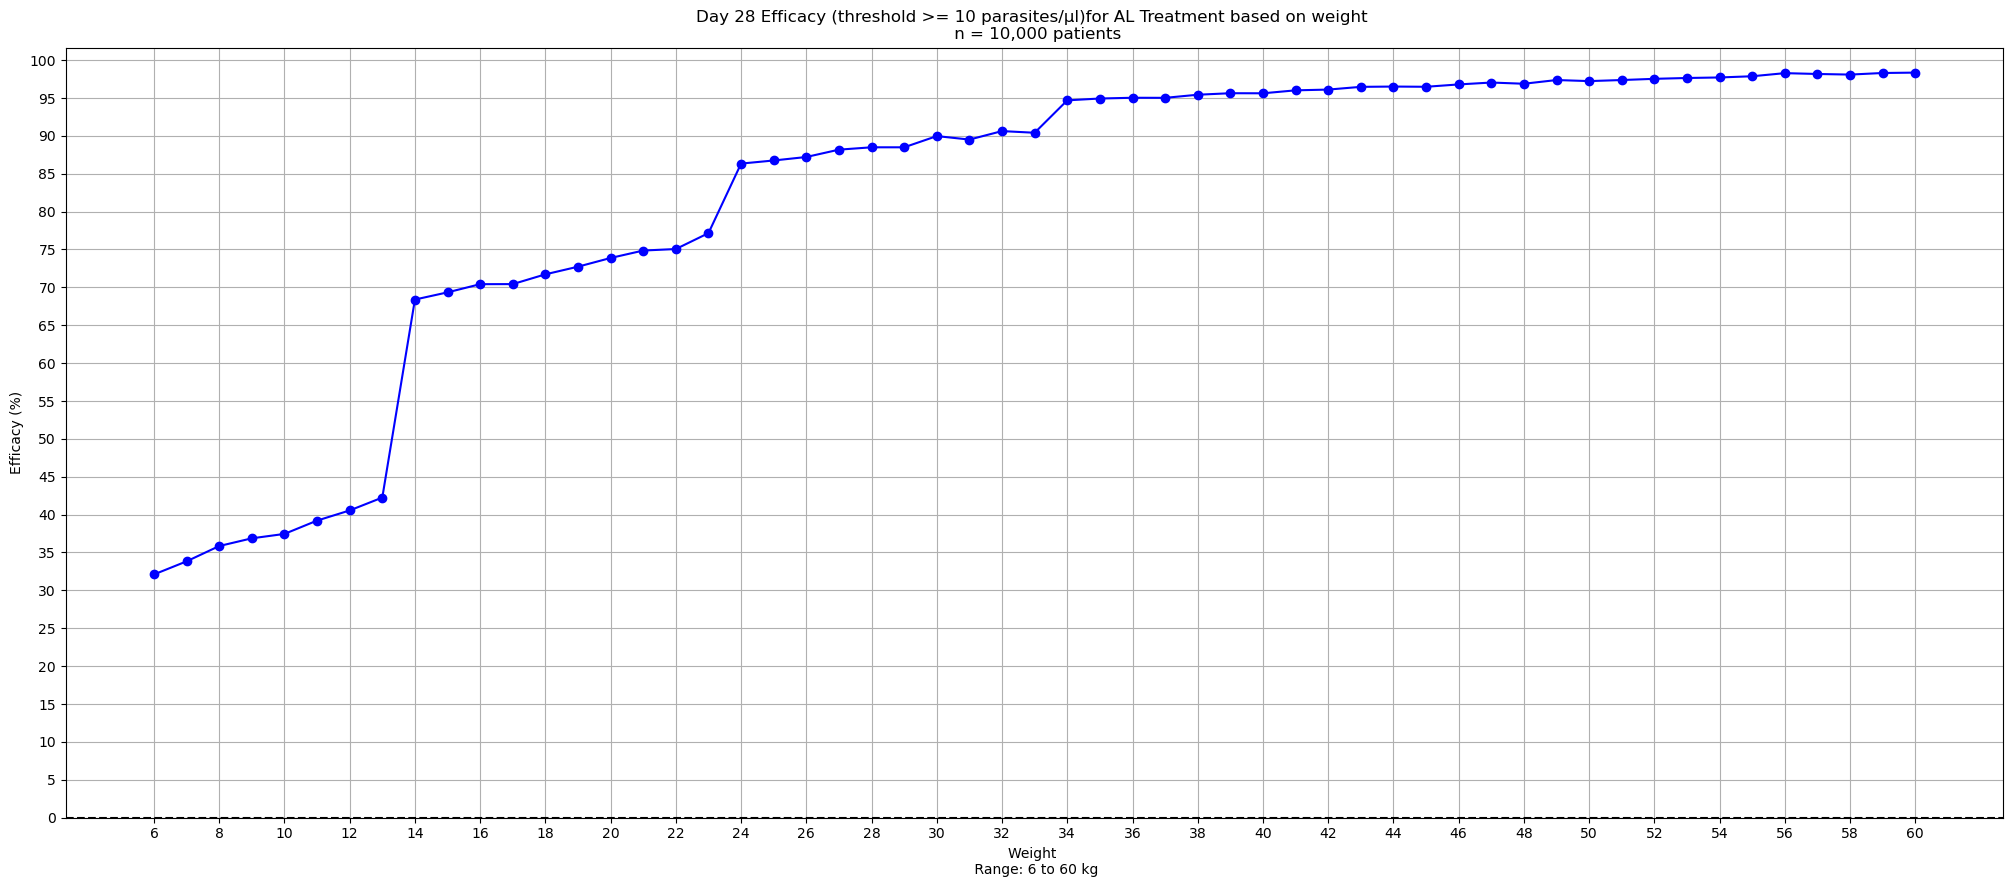

In [43]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl)for AL Treatment based on weight \n n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_01.png")  # Save the plot as a PNG file
plt.show()

<br>

# Repeating the experiment for weight groups 0-4, 5-7, 8-10, 11-16, 17 to 24 and 25 to 35

# Plotting the concentration-time, time-effect and concentration-effect graphs

# 1 tablet of dha = 40 mg, 1 tablet of lum = 120 mg

In [2]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

### Weight group 0-4 (0 tablets/ 0mg of dha, 0 tablets/ 0mg of lum)

#### Not included 0kg as it results in NaN, however code has been edited to handle 0kg

In [147]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 1
max_weight = 4

# Define values
weight_values = list(range(min_weight, max_weight+1, 1))

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []

print(weight_values)
print(len(weight_values))

#Saving weights for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_group_01.txt', weight_values, delimiter=',', fmt='%5f')



[1, 2, 3, 4]
4


In [148]:
import subprocess
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to run a single simulation for a given weight value
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_group_01_run_{idx+1}.csv", index=False)

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            efficacy = (100 - ((failed_treatment_count / total_patients) * 100))
            if np.isnan(efficacy):
                efficacy = np.nan
        return (idx, efficacy, df_weight, failed_treatment_count)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize an array to store the efficacies
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []
failed_patients = np.zeros(len(weight_values))

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the trial_efficacy array with the results and store DataFrames
for idx, efficacy, df_weight, failed_treatment_count in results:
    trial_efficacy[idx] = efficacy
    failed_patients[idx] = failed_treatment_count
    dataframes_results.append(df_weight)

# Create a DataFrame with weight values and efficacies
df_efficacy = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df_efficacy.to_pickle("pkpd_AL_weight_calibration_group_01.pyobj")

# Save the DataFrame to a CSV file
df_efficacy.to_csv("pkpd_AL_weight_calibration_group_01.csv", index=False)

#Saving failed patient count for future reference
np.savetxt('pkpd_AL_weight_calibration_group_01_patient_failure.txt', failed_patients, delimiter=',', fmt='%2f')

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]

DataFrame saved as pickle and CSV files successfully.


/tmp/ipykernel_7897/4009194260.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like


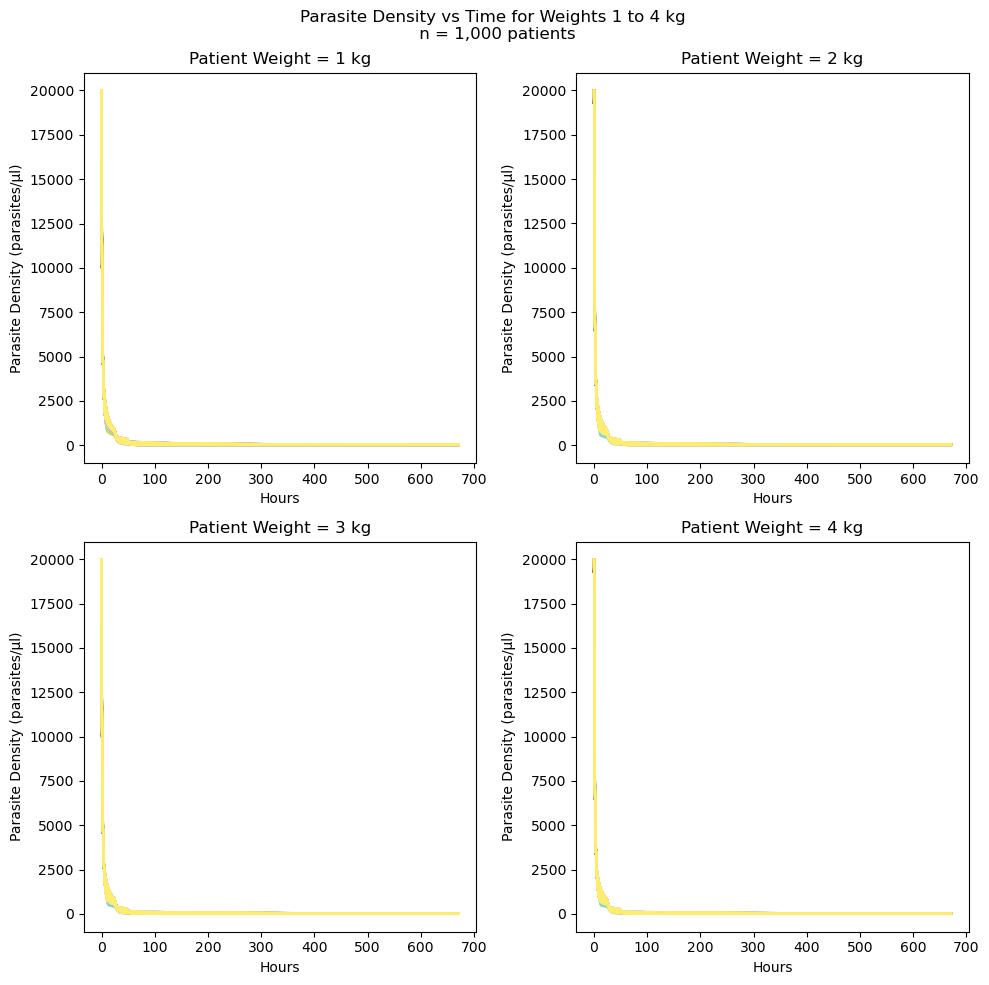

In [149]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        ax.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=colormap(j))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Parasite Density (parasites/μl)')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Parasite Density vs Time for Weights 1 to 4 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_parasitedensity.png")
plt.tight_layout()
plt.show()

/tmp/ipykernel_7897/2479113920.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like


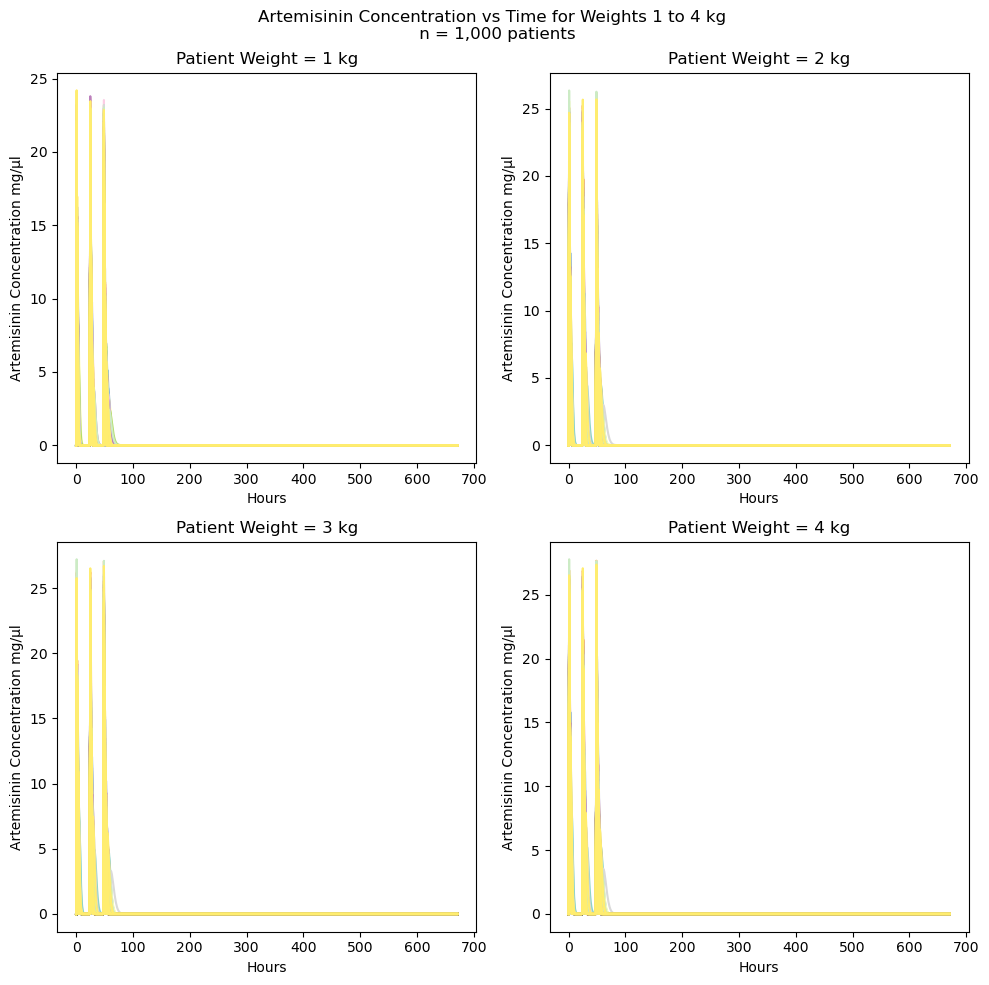

In [150]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=colormap(j))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Artemisinin Concentration mg/μl')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Artemisinin Concentration vs Time for Weights 1 to 4 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_art_conc.png")
plt.tight_layout()
plt.show()

/tmp/ipykernel_7897/969827901.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like


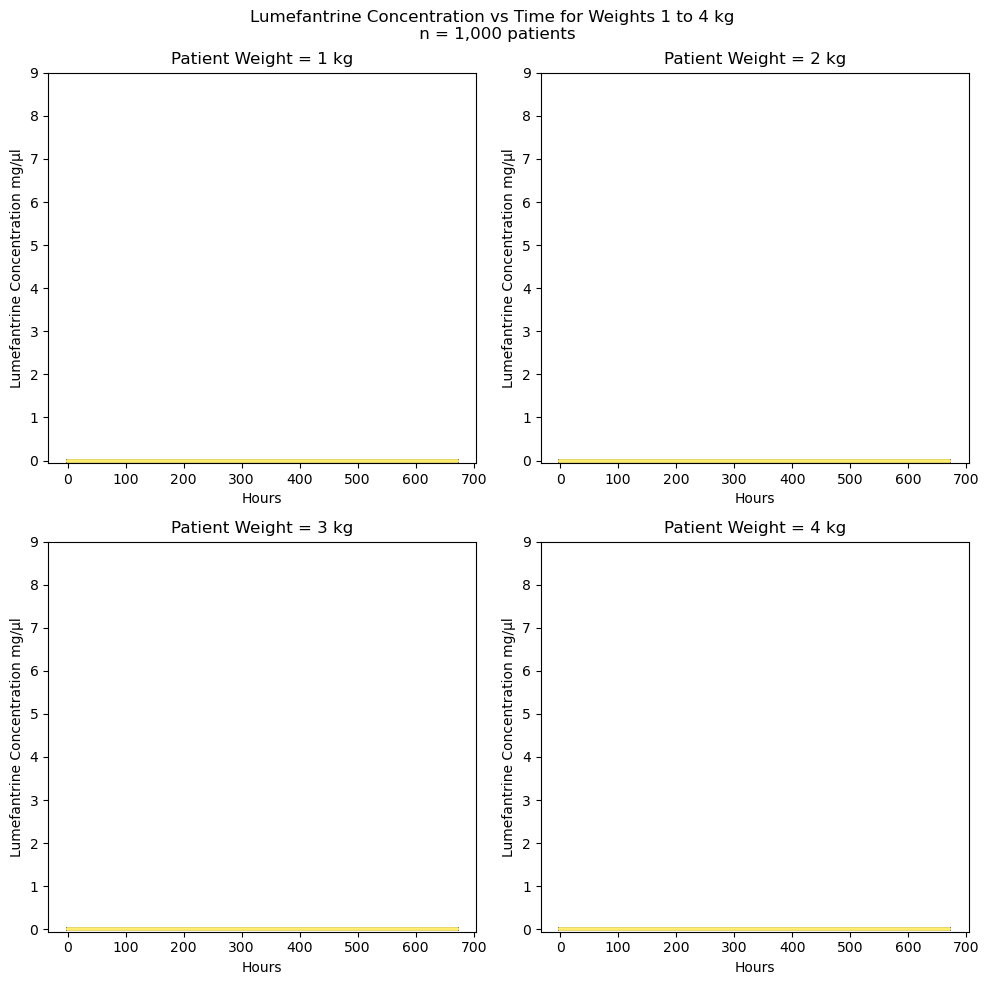

In [151]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=colormap(j))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Lumefantrine Concentration mg/μl')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Lumefantrine Concentration vs Time for Weights 1 to 4 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_lum_conc.png")
plt.tight_layout()
plt.show()

<br>

### Weight group 5-7.99 kg (0.5 tablets/ 20mg of dha, 1 tablet/ 120mg of lum)
### Weight group 8.0 - 10.99 kg (0.75 tablets/ 30mg of dha, 1 tablet/ 120mg of lum)
### Weight group 11.0 - 16.99 kg (1 tablet/ 40mg of dha, 1 or 2 tablets/ 120mg or 240mg of lum)
### Weight group 17.0 - 24.99 kg (1.5 tablets/ 60mg of dha, 1 or 2 tablets/ 120mg or 240mg of lum)

<br>

### DHA and LUM have different weight groups
#### To keep things simple, group 02 will be 5 - 23 kg

In [127]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 5
max_weight = 23

# Define values
weight_values = list(range(min_weight, max_weight, 3))

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []

print(weight_values)
print(len(weight_values))

#Saving weights for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_group_02.txt', weight_values, delimiter=',', fmt='%5f')


[5, 8, 11, 14, 17, 20]
6


In [128]:
import subprocess
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to run a single simulation for a given weight value
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_group_02_run_{idx+1}.csv", index=False)

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            efficacy = (100 - ((failed_treatment_count / total_patients) * 100))
            if np.isnan(efficacy):
                efficacy = np.nan
        return (idx, efficacy, df_weight, failed_treatment_count)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize an array to store the efficacies
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []
failed_patients = np.zeros(len(weight_values))

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the trial_efficacy array with the results and store DataFrames
for idx, efficacy, df_weight, failed_treatment_count in results:
    trial_efficacy[idx] = efficacy
    failed_patients[idx] = failed_treatment_count
    dataframes_results.append(df_weight)

# Create a DataFrame with weight values and efficacies
df_efficacy = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df_efficacy.to_pickle("pkpd_AL_weight_calibration_group_02.pyobj")

# Save the DataFrame to a CSV file
df_efficacy.to_csv("pkpd_AL_weight_calibration_group_02.csv", index=False)

#Saving failed patient count for future reference
np.savetxt('pkpd_AL_weight_calibration_group_02_patient_failure.txt', failed_patients, delimiter=',', fmt='%2f')

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 6/6 [00:36<00:00,  6.14s/it]

DataFrame saved as pickle and CSV files successfully.


/tmp/ipykernel_7897/648977926.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like


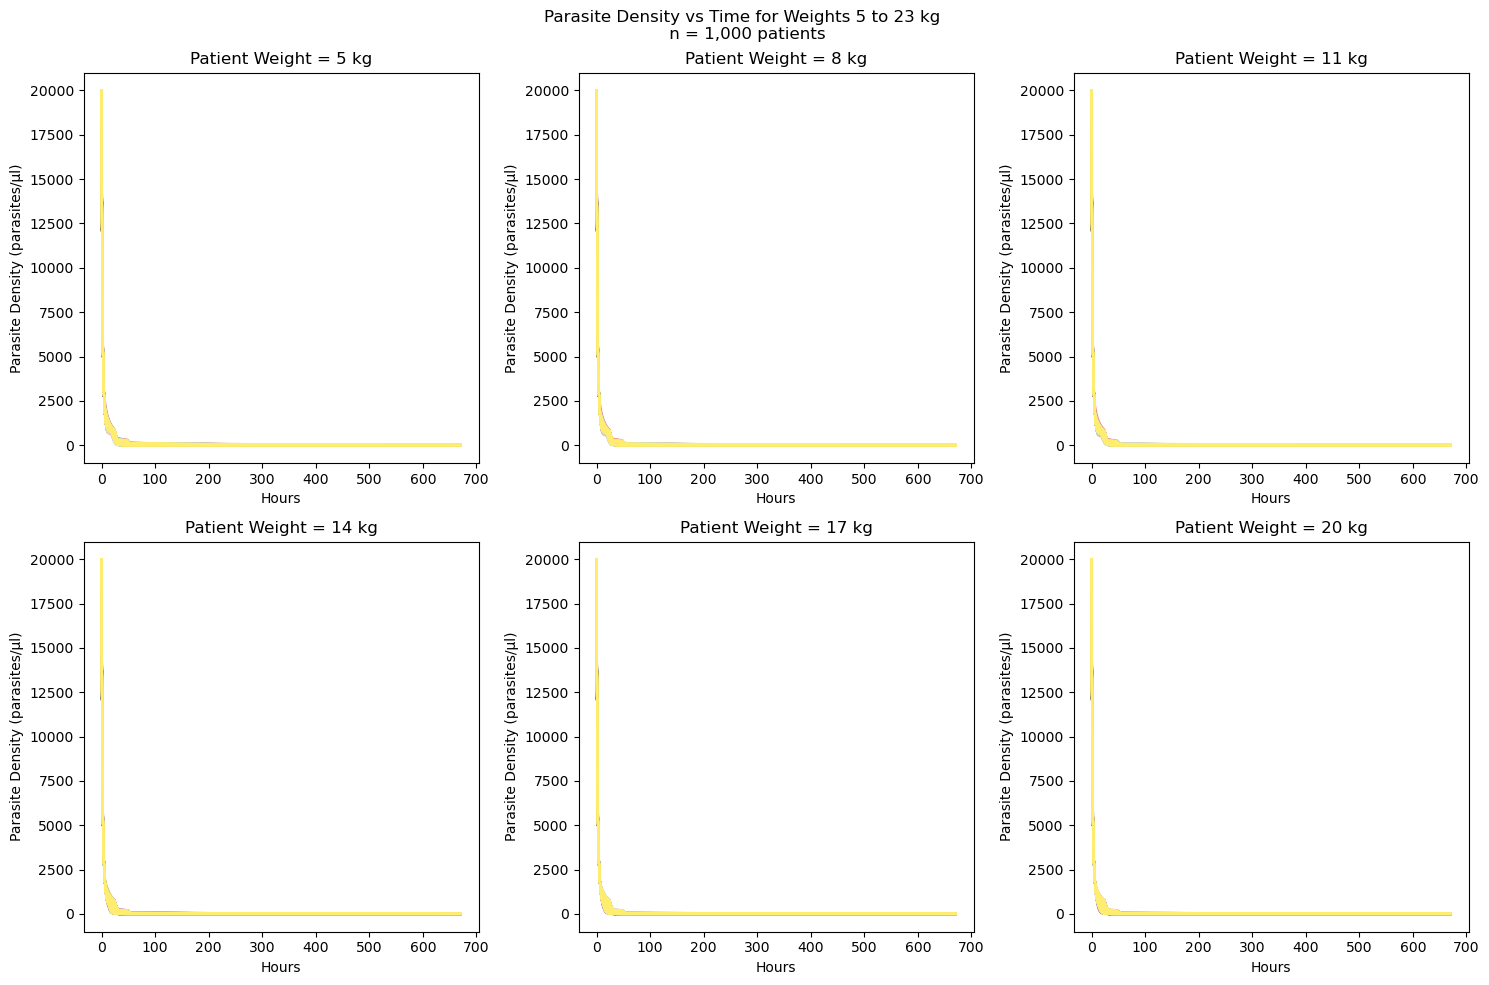

In [134]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        ax.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=colormap(j))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Parasite Density (parasites/μl)')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Parasite Density vs Time for Weights 5 to 23 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_02_parasitedensity.png")
plt.tight_layout()
plt.show()

/tmp/ipykernel_7897/4248594277.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like


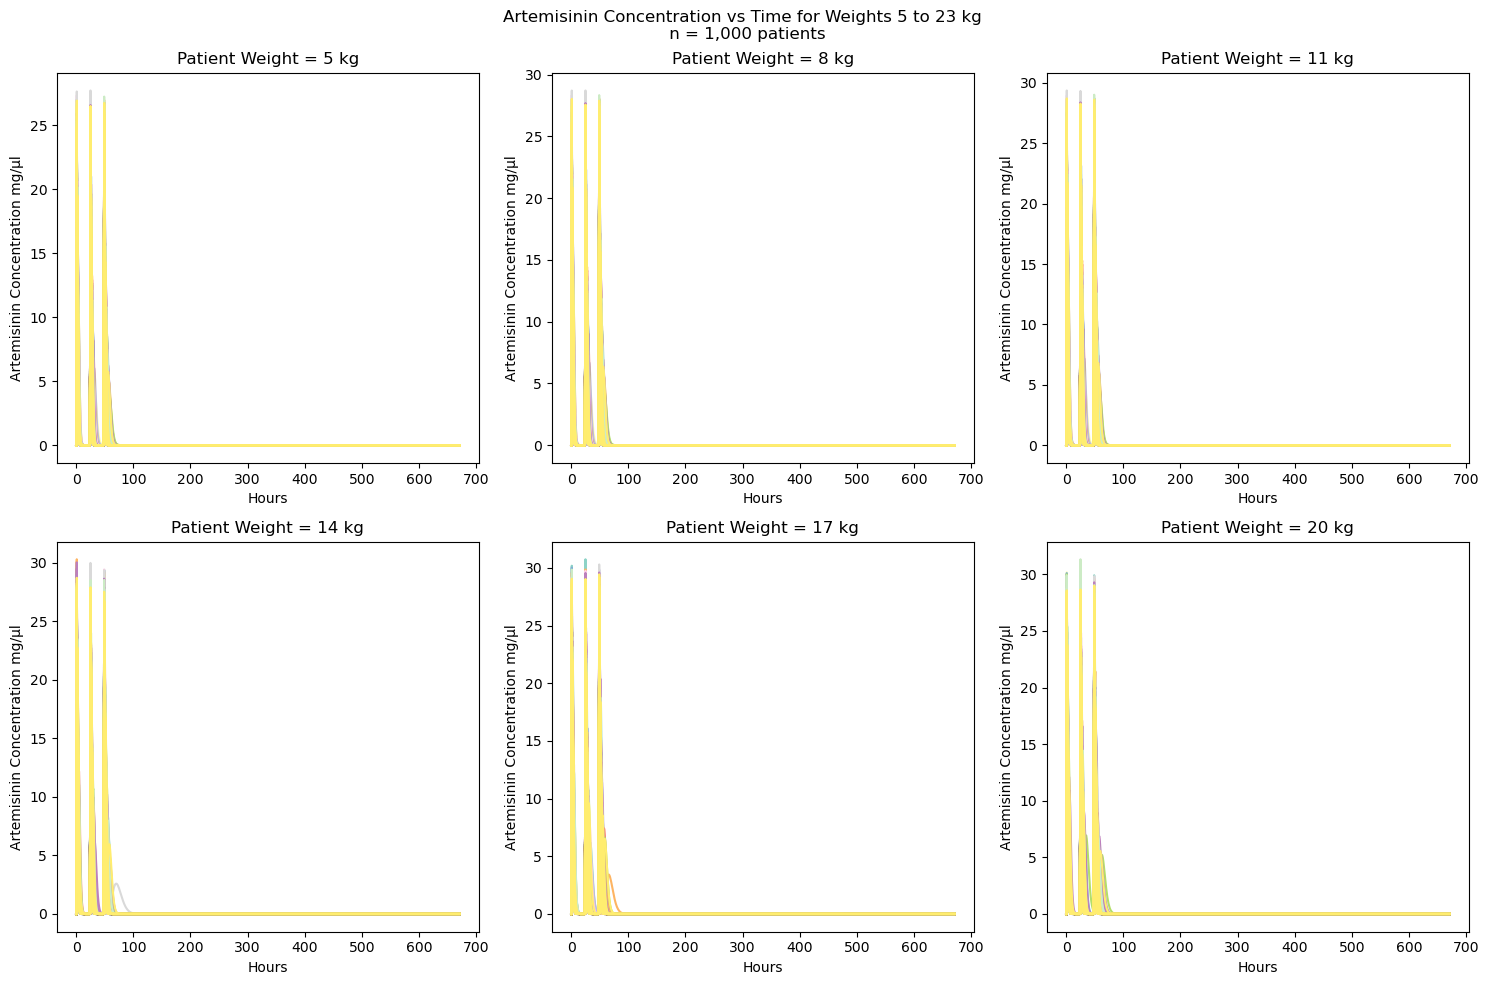

In [136]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=colormap(j))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Artemisinin Concentration mg/μl')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Artemisinin Concentration vs Time for Weights 5 to 23 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_02_art_conc.png")
plt.tight_layout()
plt.show()

/tmp/ipykernel_7897/2962579531.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like
/tmp/ipykernel_7897/2962579531.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pid['COMP2CONC_LUM'] = df_pid['COMP2CONC_LUM'] / 100


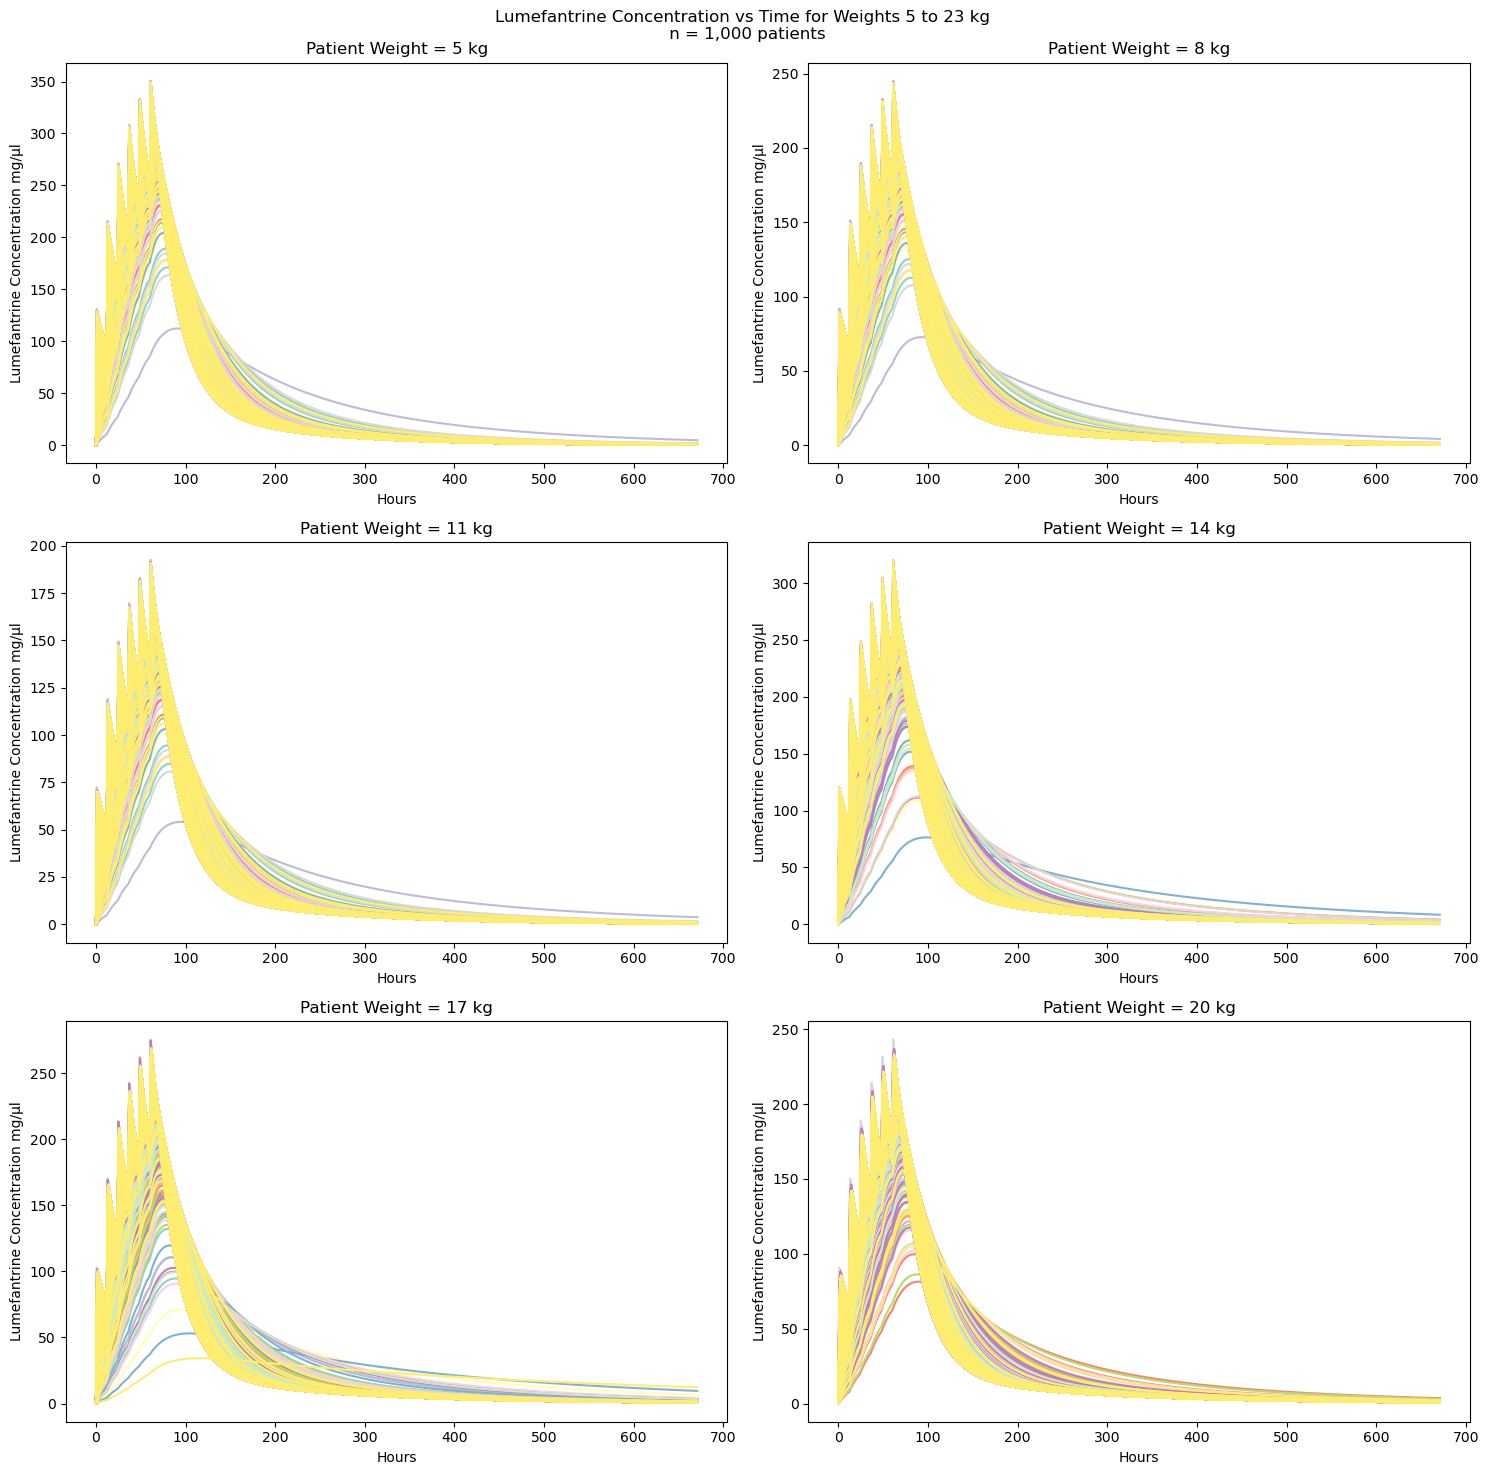

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm



#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = cm.get_cmap('Set3', num_pids)  # You can choose any colormap you like

nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        #Convert COMP2CONC_LUM to mg/μl from μg/μl
        df_pid['COMP2CONC_LUM'] = df_pid['COMP2CONC_LUM'] / 100
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=colormap(j))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Lumefantrine Concentration mg/μl')
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

fig.suptitle("Lumefantrine Concentration vs Time for Weights 5 to 23 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_02_lum_conc.png")
plt.tight_layout()
plt.show()

<br>

### Weight group 25 - 35.99 kg (2 tablets/ 80mg of dha, 3 or 4 tablets/ 360mg or 480mg of lum)
### Weight group 36 - 59.99 kg (3 tablets/ 120mg of dha, 4 tablets/ 480mg of lum)
### Weight group 60 - 79.99 kg (4 tablet/ 160mg of dha, 4 tablets/ 480mg of lum)
### Weight group >= 80 kg (5 tablets/ 200mg of dha, 4 tablets/ 480mg of lum)

In [209]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 25
max_weight = 95

# Define values
weight_values = list(range(min_weight, max_weight+1, 5))

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []

print(weight_values)
print(len(weight_values))

#Saving weights for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_group_03.txt', weight_values, delimiter=',', fmt='%5f')


[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
15


In [210]:
import subprocess
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to run a single simulation for a given weight value
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_group_03_run_{idx+1}.csv", index=False)

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            efficacy = (100 - ((failed_treatment_count / total_patients) * 100))
            if np.isnan(efficacy):
                efficacy = np.nan
        return (idx, efficacy, df_weight, failed_treatment_count)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize an array to store the efficacies
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []
failed_patients = np.zeros(len(weight_values))

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the trial_efficacy array with the results and store DataFrames
for idx, efficacy, df_weight, failed_treatment_count in results:
    trial_efficacy[idx] = efficacy
    failed_patients[idx] = failed_treatment_count
    dataframes_results.append(df_weight)

# Create a DataFrame with weight values and efficacies
df_efficacy = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df_efficacy.to_pickle("pkpd_AL_weight_calibration_group_03.pyobj")

# Save the DataFrame to a CSV file
df_efficacy.to_csv("pkpd_AL_weight_calibration_group_03.csv", index=False)

#Saving failed patient count for future reference
np.savetxt('pkpd_AL_weight_calibration_group_03_patient_failure.txt', failed_patients, delimiter=',', fmt='%2f')

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 15/15 [01:22<00:00,  5.48s/it]

DataFrame saved as pickle and CSV files successfully.


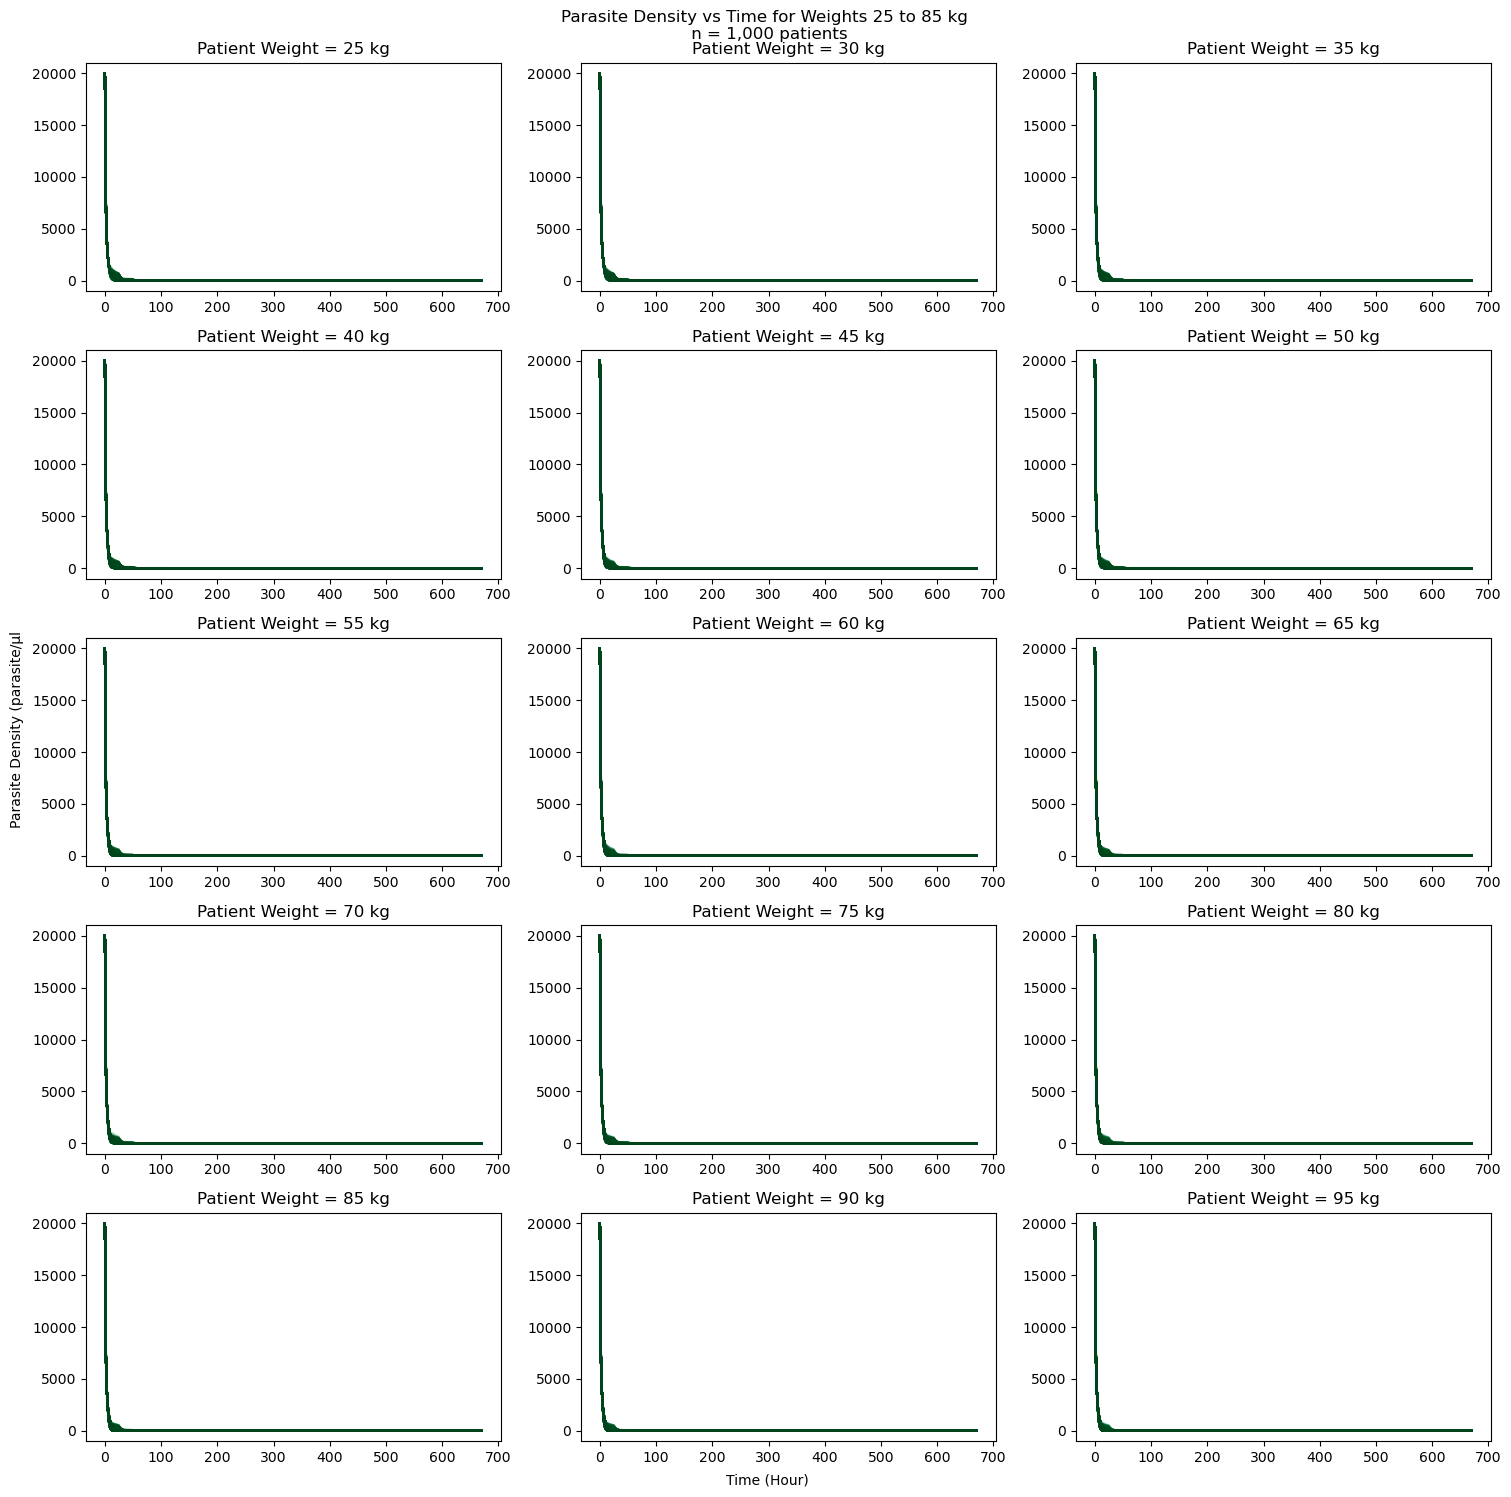

In [225]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

nrows = 5
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        color = colormap(norm(j))  # Normalize j for color mapping
        ax.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

#Set X and Y Labels for the entire plot
fig.text(0.5, 0, 'Time (Hour)', ha='center', va='center')
fig.text(0, 0.5, 'Parasite Density (parasite/μl', ha='center', va='center', rotation='vertical')
fig.suptitle("Parasite Density vs Time for Weights 25 to 85 kg \n n = 1,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_03_parasitedensity.png")
plt.tight_layout()
plt.show()

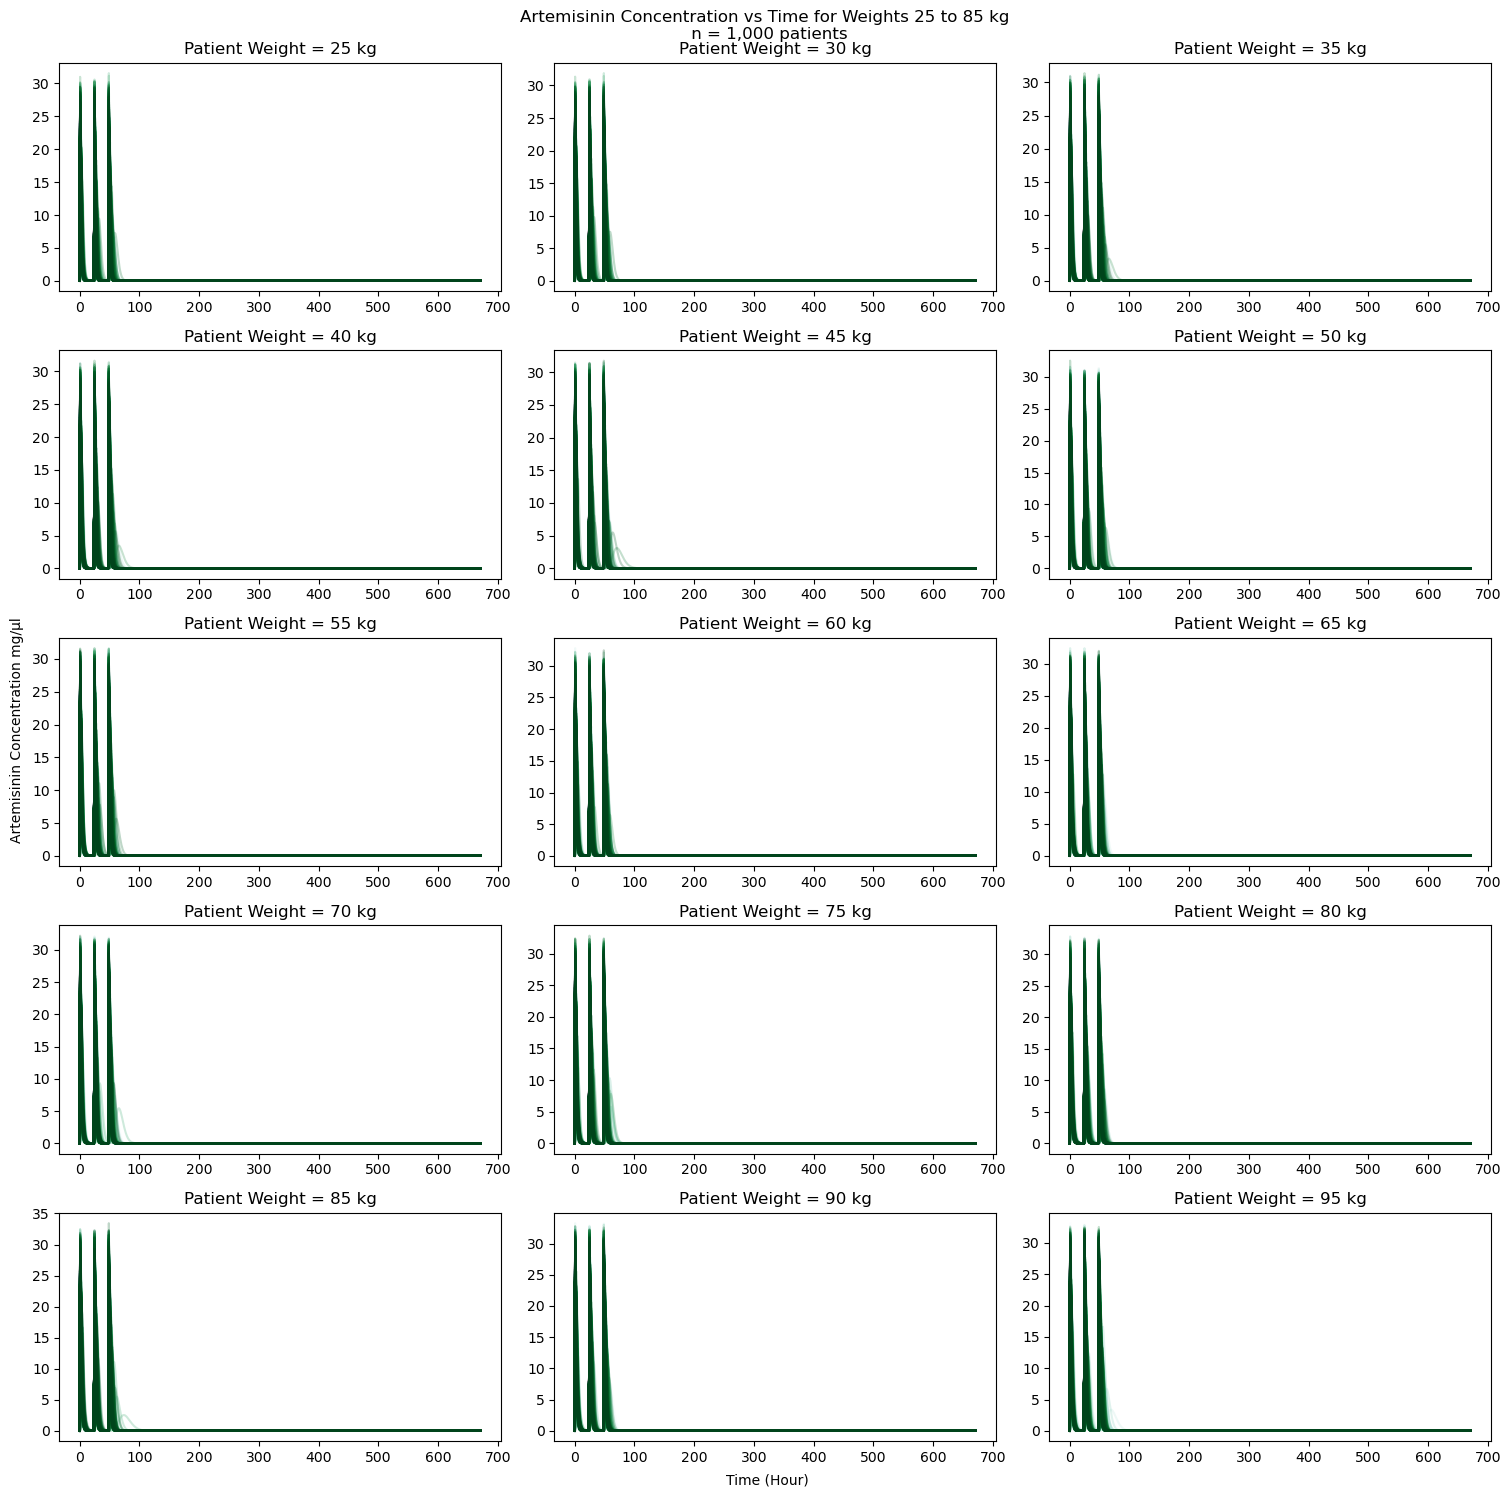

In [223]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df['PID'].unique())

# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

nrows = 5
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    for j, pid in enumerate(df['PID'].unique()):
        df_pid = df[df['PID'] == pid]
        color = colormap(norm(j))  # Normalize j for color mapping
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color= color, alpha=0.25)
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

#Set X and Y Labels for the entire plot
fig.text(0.5, 0, 'Time (Hour)', ha='center', va='center')
fig.text(0, 0.5, 'Artemisinin Concentration mg/μl', ha='center', va='center', rotation='vertical')
fig.suptitle("Artemisinin Concentration vs Time for Weights 25 to 85 kg \n n = 1,000 patients")

plt.savefig("pkpd_AL_weight_calibration_group_03_art_conc.png")
plt.tight_layout()
plt.show()

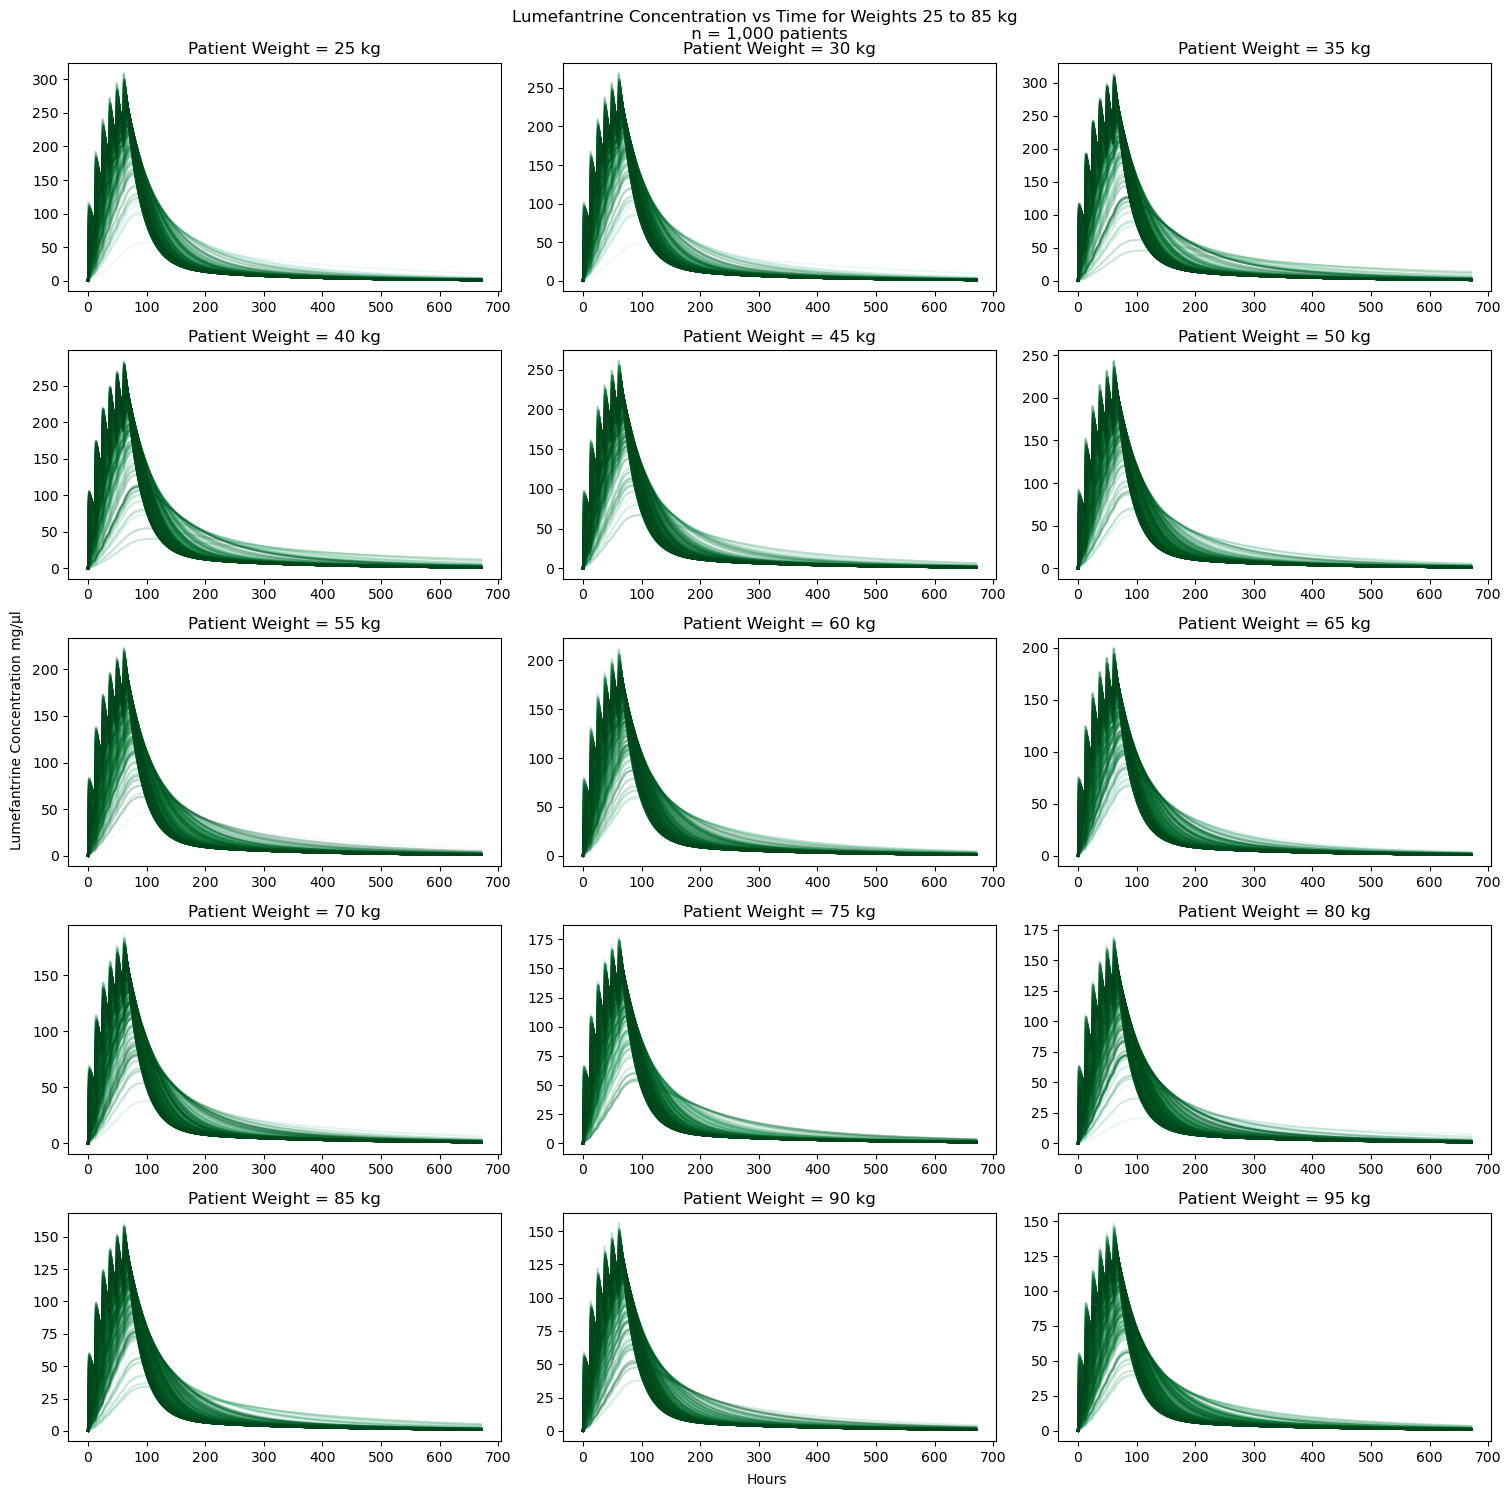

In [218]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Define the number of unique PIDs
num_pids = max(len(df['PID'].unique()) for df in dataframes_results)

# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

nrows = 5
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, df in enumerate(dataframes_results):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    
    unique_pids = df['PID'].unique()
    for j, pid in enumerate(unique_pids):
        df_pid = df[df['PID'] == pid].copy()  # Avoid SettingWithCopyWarning
        df_pid['COMP2CONC_LUM'] /= 100  # Modify safely
        
        color = colormap(norm(j))  # Normalize j for color mapping
        ax.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    ax.set_title(f"Patient Weight = {weight_values[i]} kg")

#Set X and Y Labels for the entire plot
fig.text(0.5, 0, 'ime (Hour)', ha='center', va='center')
fig.text(0, 0.5, 'Lumefantrine Concentration (mg/μl)', ha='center', va='center', rotation='vertical')
fig.suptitle("Lumefantrine Concentration vs Time for Weights 25 to 85 kg \n n = 1,000 patients")
# Add space between the super title and the subplots
plt.subplots_adjust(top=0.88)  # Adjust the top parameter to add space

plt.tight_layout()
plt.savefig("pkpd_AL_weight_calibration_group_03_lum_conc.png")
plt.show()
